In [ ]:
%run ../talktools.py

# xarray

<img src="https://docs.xarray.dev/en/stable/_static/dataset-diagram-logo.png">

Adding dimensions names and coordinate indexes to numpy’s ndarray makes many powerful array operations possible:

- Apply operations over dimensions by name: `x.sum('time')`.
- Select values by label instead of integer location: `x.loc['2022-01-01']` or `x.sel(time='2022-01-01')`.
- Mathematical operations (e.g., `x - y`) vectorize across multiple dimensions (array broadcasting) based on dimension names, not shape.
- Flexible split-apply-combine operations with groupby: `x.groupby('time.dayofyear').mean()`.
- Database like alignment based on coordinate labels that smoothly handles missing values: `x, y = xr.align(x, y, join='outer')`.
- Keep track of arbitrary metadata in the form of a Python dictionary: x.attrs.

Works with dask too.

- **DataArray**: labeled, N-dimensional array. It is an N-D generalization of a pandas.Series. 

- **Dataset** multi-dimensional, in-memory array database. It is a dict-like container of DataArray objects aligned along any number of shared dimensions, and serves a similar purpose in xarray to the pandas.DataFrame

<img src="https://docs.xarray.dev/en/stable/_images/dataset-diagram.png">

http://xarray.pydata.org/en/stable/why-xarray.html#features

In [ ]:
#!conda install xarray netCDF4 -y

In [1]:
import xarray as xr
import numpy as np
import pandas as pd

Let's create a small timeseries of data of wind speed at different California airports.

In [2]:
wind_array = 10*np.random.rand(4, 3) + 3

locs = ["OAK", "LAX", "SFO"]

times = pd.date_range("2022-02-28", periods=4)

In [3]:
foo = xr.DataArray(wind_array, coords=[times, locs], dims=["time", "space"])

In [4]:
foo

<xarray.DataArray (time: 4, space: 3)>
array([[ 8.33792595, 11.04108603,  9.17754145],
       [12.26953163,  7.54194803,  6.1874263 ],
       [ 6.30352982,  3.44333561,  7.22996825],
       [10.29615418,  3.13924163, 10.5364176 ]])
Coordinates:
  * time     (time) datetime64[ns] 2022-02-28 2022-03-01 2022-03-02 2022-03-03
  * space    (space) <U3 'OAK' 'LAX' 'SFO'

In [5]:
foo.dims

('time', 'space')

In [6]:
type(foo.values)

numpy.ndarray

In [7]:
foo.attrs

{}

In [8]:
foo.name = "airport speed"

foo.attrs["units"] = "m/s"

In [9]:
# positional and by integer label, like numpy
foo[[0]]

<xarray.DataArray 'airport speed' (time: 1, space: 3)>
array([[ 8.33792595, 11.04108603,  9.17754145]])
Coordinates:
  * time     (time) datetime64[ns] 2022-02-28
  * space    (space) <U3 'OAK' 'LAX' 'SFO'
Attributes:
    units:    m/s

In [10]:
foo["airport_ranking"] = ("space", [1, 3, 2])

In [ ]:
# by dimension name and coordinate label
foo.sel(space=['OAK'])

In [ ]:
foo.mean(dim='time')

In [ ]:
!rm /tmp/wind.nc
foo.to_netcdf("/tmp/wind.nc")

In [ ]:
ds1 = xr.open_dataset("/tmp/wind.nc")

In [ ]:
ds1.sel(space="LAX")

## OPeNDAP

`xarray` includes support for OPeNDAP (via the netCDF4 library or Pydap), which lets us access large datasets over HTTP. Let's get some  climate data from http://thredds.northwestknowledge.net:8080/thredds/catalog.html

In [32]:
# temp: tasmax/tasmin, RH: rhsmax/rhsmin, precipitation: pr
# downward shortwave solar radiation(rsds), eastward wind(uas), 
# northward wind(vas), and specific humidity(huss)

datatype = "tasmax" 

data_path = ("http://thredds.northwestknowledge.net:8080/"
             f"thredds/dodsC/agg_macav2metdata_{datatype}"
             "_BNU-ESM_r1i1p1_historical_1950_2005_CONUS_monthly.nc"
            )

max_temp_xr  = xr.open_dataset(data_path)  
# View xarray object
max_temp_xr

<xarray.Dataset>
Dimensions:          (lat: 585, crs: 1, lon: 1386, time: 672)
Coordinates:
  * lat              (lat) float64 25.06 25.1 25.15 25.19 ... 49.31 49.35 49.4
  * crs              (crs) int32 1
  * lon              (lon) float64 235.2 235.3 235.3 235.4 ... 292.9 292.9 292.9
  * time             (time) object 1950-01-15 00:00:00 ... 2005-12-15 00:00:00
Data variables:
    air_temperature  (time, lat, lon) float32 ...
Attributes: (12/46)
    description:                     Multivariate Adaptive Constructed Analog...
    id:                              MACAv2-METDATA
    naming_authority:                edu.uidaho.reacch
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    Metadata_Link:                   
    cdm_data_type:                   FLOAT
    ...                              ...
    contributor_role:                Postdoctoral Fellow
    publisher_name:                  REACCH
    publisher_email:                 reacch@uidaho.edu
    publisher_url:                   http://www.reacchpna.org/
    license:                         Creative Commons CC0 1.0 Universal Dedic...
    coordinate_system:               WGS84,EPSG:4326

In [28]:
# View first 5 latitude values
max_temp_xr["air_temperature"]["lat"].values[:5]

print("The min and max latitude values in the data is:", 
      max_temp_xr["air_temperature"]["lat"].values.min(), 
      max_temp_xr["air_temperature"]["lat"].values.max())
print("The min and max longitude values in the data is:", 
      max_temp_xr["air_temperature"]["lon"].values.min(), 
      max_temp_xr["air_temperature"]["lon"].values.max())

print("The earliest date in the data is:", max_temp_xr["air_temperature"]["time"].values.min())
print("The latest date in the data is:", max_temp_xr["air_temperature"]["time"].values.max())    


The min and max latitude values in the data is: 25.063077926635742 49.39602279663086
The min and max longitude values in the data is: 235.22784423828125 292.93524169921875
The earliest date in the data is: 1950-01-15 00:00:00
The latest date in the data is: 2005-12-15 00:00:00


In [13]:
max_temp_xr.attrs

{'description': 'Multivariate Adaptive Constructed Analogs (MACA) method, version 2.3,Dec 2013.',
 'id': 'MACAv2-METDATA',
 'naming_authority': 'edu.uidaho.reacch',
 'Metadata_Conventions': 'Unidata Dataset Discovery v1.0',
 'Metadata_Link': '',
 'cdm_data_type': 'FLOAT',
 'title': 'Monthly aggregation of downscaled daily meteorological data of Monthly Average of Daily Maximum Near-Surface Air Temperature from College of Global Change and Earth System Science, Beijing Normal University (BNU-ESM) using the run r1i1p1 of the historical scenario.',
 'summary': 'This archive contains monthly downscaled meteorological and hydrological projections for the Conterminous United States at 1/24-deg resolution. These monthly values are obtained by aggregating the daily values obtained from the downscaling using the Multivariate Adaptive Constructed Analogs (MACA, Abatzoglou, 2012) statistical downscaling method with the METDATA (Abatzoglou,2013) training dataset. The downscaled meteorological vari

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#!pip install nc-time-axis

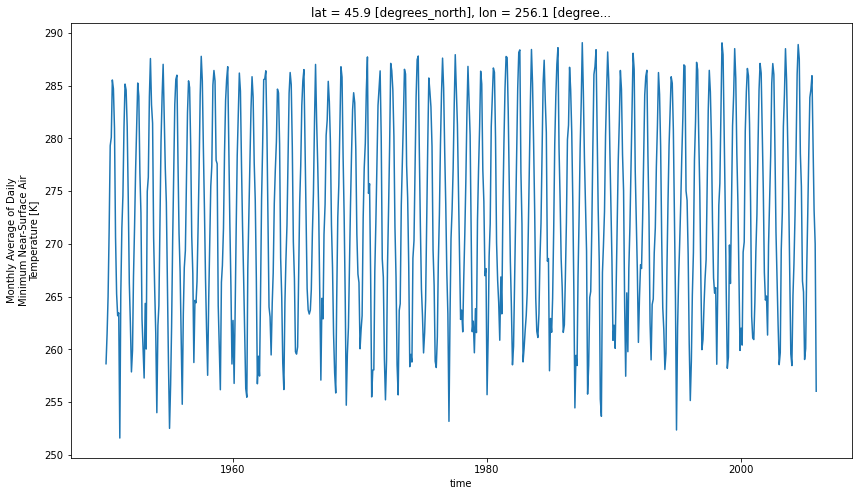

In [30]:
key=500
longitude = max_temp_xr["air_temperature"]["lon"].values[key]
latitude = max_temp_xr["air_temperature"]["lat"].values[key]

one_point = max_temp_xr["air_temperature"].sel(lat=latitude,
                                               lon=longitude)
plt.figure(figsize=(14,8))

one_point.plot()

In [17]:
KOAK = 37.7212982177734,-122.221000671387 + 360

In [18]:
oak = max_temp_xr.interp(lon=KOAK[1], lat=KOAK[0])

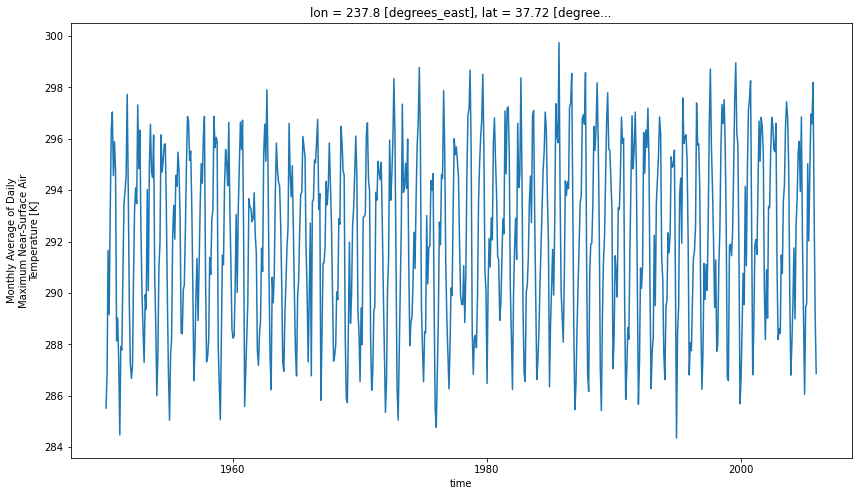

In [26]:

plt.figure(figsize=(14,8))
oak["air_temperature"].plot()

## Other DBs

**Columnar databases** - e.g., MonetDB

**Distributed DBs** - HBase, BigTable

**Cloud** - AWS Athena, AWS Redshift, Google BigTable


